 **Predicting calorie expenditure**. The primary goal was to develop a robust machine learning model capable of accurately estimating the number of calories burned based on various physiological and exercise-related features. The data for this analysis was sourced from the Kaggle competition "Playground Series - Season 5, Episode 5" ([https://www.kaggle.com/competitions/playground-series-s5e5/data](https://www.kaggle.com/competitions/playground-series-s5e5/data)).

The project involved several key stages:

1.  **Data Preprocessing and Extensive Feature Engineering:** Initial data exploration was followed by the creation of new, potentially more informative features. This included calculating Body Mass Index (BMI), generating various ratio features (e.g., exercise intensity), creating polynomial features (squared and square root transformations), and engineering interaction terms between existing features to capture complex relationships. The categorical 'Sex' feature was also appropriately encoded for model consumption.
2.  **Advanced Model Training:** Three powerful gradient boosting algorithms—XGBoost, LightGBM, and CatBoost—were trained and evaluated. A K-Fold cross-validation strategy was employed to ensure the models' performance was generalizable and to prevent overfitting.
3.  **Ensemble Learning:** To further enhance predictive accuracy, the predictions from the individual XGBoost, LightGBM, and CatBoost models were combined using a weighted averaging ensemble technique, where weights were determined based on individual model cross-validation performance.
4.  **Performance Evaluation:** The models were rigorously evaluated using the Root Mean Squared Log Error (RMSLE) metric on the original scale of calorie predictions.

**Key findings** from this project demonstrated the effectiveness of the combined approach. The feature engineering steps were crucial in providing the models with rich information, and the ensemble of gradient boosting machines ultimately aimed to achieve a competitive RMSLE score, indicating a strong predictive capability for calorie expenditure. The project highlights a systematic workflow for tackling regression problems, from data understanding and feature creation to advanced modeling and ensembling.

---

**Portfolio Entry Details:**

* **Author:** YI LUO
* **Date:** 2025-05-31
* **Data Source:** [Kaggle Playground Series S5E5](https://www.kaggle.com/competitions/playground-series-s5e5/data)

In [1]:
import pandas as pd
import numpy as np
import os
import time
import logging
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_log_error # Using RMSLE directly for clarity
from sklearn.preprocessing import StandardScaler

# import lightgbm # This can remain if other lightgbm.xxx calls are made, or be removed if not.
from lightgbm import LGBMRegressor
from lightgbm.callback import early_stopping as lgb_early_stopping # Specific import for early_stopping
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

# from category_encoders import TargetEncoder # Keep for potential future use

from tqdm.auto import tqdm
from itertools import combinations
import warnings
warnings.simplefilter('ignore')

In [2]:
# --- 1. Load Data ---
print("Loading data...")
train_df = pd.read_csv("./00_data/train.csv")
test_df = pd.read_csv("./00_data/test.csv")
sample_submission = pd.read_csv("./00_data/sample_submission.csv")
print("Data loaded successfully.")
print(f"Train shape: {train_df.shape}, Test shape: {test_df.shape}")

# --- 2. Basic EDA (Placeholder for more detailed EDA) ---
print("\n--- Basic EDA ---")
print("Train data description:")
print(train_df.describe())
print("\nMissing values in train_df:\n", train_df.isnull().sum())
print("\nMissing values in test_df:\n", test_df.isnull().sum())

Loading data...
Data loaded successfully.
Train shape: (750000, 9), Test shape: (250000, 8)

--- Basic EDA ---
Train data description:
                  id            Age         Height         Weight  \
count  750000.000000  750000.000000  750000.000000  750000.000000   
mean   374999.500000      41.420404     174.697685      75.145668   
std    216506.495284      15.175049      12.824496      13.982704   
min         0.000000      20.000000     126.000000      36.000000   
25%    187499.750000      28.000000     164.000000      63.000000   
50%    374999.500000      40.000000     174.000000      74.000000   
75%    562499.250000      52.000000     185.000000      87.000000   
max    749999.000000      79.000000     222.000000     132.000000   

            Duration     Heart_Rate      Body_Temp       Calories  
count  750000.000000  750000.000000  750000.000000  750000.000000  
mean       15.421015      95.483995      40.036253      88.282781  
std         8.354095       9.449845    

In [3]:
# --- 3. Feature Engineering ---
print("\n--- Feature Engineering ---")
def feature_engineer(df):
    df_fe = df.copy()

    # Original numerical features
    numerical_features = ["Age", "Height", "Weight", "Duration", "Heart_Rate", "Body_Temp"]

    # a. BMI (Body Mass Index)
    # Height is in cm, convert to meters for BMI calculation
    df_fe['BMI'] = df_fe['Weight'] / ((df_fe['Height'] / 100) ** 2)

    # b. Ratio Features
    df_fe['Duration_x_Heart_Rate'] = df_fe['Duration'] * df_fe['Heart_Rate'] # Interaction
    df_fe['Intensity'] = df_fe['Heart_Rate'] / (df_fe['Duration'] + 1e-6) # Avoid division by zero
    df_fe['Weight_x_Height'] = df_fe['Weight'] * df_fe['Height']
    df_fe['Age_x_BMI'] = df_fe['Age'] * df_fe['BMI']
    df_fe['Body_Temp_x_Duration'] = df_fe['Body_Temp'] * df_fe['Duration']


    # c. Polynomial Features (Squared and Square Root)
    for col in numerical_features + ['BMI']: # Include BMI here
        df_fe[f'{col}_sq'] = df_fe[col] ** 2
        df_fe[f'{col}_sqrt'] = np.sqrt(df_fe[col].clip(0)) # Clip at 0 for sqrt

    # d. Cross-product terms (Interaction Features)
    # Update numerical_features to include BMI for cross terms
    extended_numerical_features = numerical_features + ['BMI']
    for i in range(len(extended_numerical_features)):
        for j in range(i + 1, len(extended_numerical_features)):
            feature1 = extended_numerical_features[i]
            feature2 = extended_numerical_features[j]
            cross_term_name = f"{feature1}_cross_{feature2}"
            df_fe[cross_term_name] = df_fe[feature1] * df_fe[feature2]

    # e. Label Encode 'Sex'
    # Done after creating interactions with original numerical features,
    # but before interactions that might use the encoded 'Sex' if desired.
    # For now, we'll encode it and XGBoost/LGBM/CatBoost can handle it.
    if 'Sex' in df_fe.columns:
        le = LabelEncoder()
        df_fe['Sex_encoded'] = le.fit_transform(df_fe['Sex'])
        # df_fe['Sex_encoded'] = df_fe['Sex_encoded'].astype('category') # Models can handle this

    # f. Interactions with Sex (using the original numerical values)
    # Example: df_fe['Sex_Male_x_Age'] = (df_fe['Sex'] == 'male').astype(int) * df_fe['Age']
    # This can be expanded. For simplicity, we'll rely on the models to pick up 'Sex_encoded' interactions.

    return df_fe

train_fe = feature_engineer(train_df.copy())
test_fe = feature_engineer(test_df.copy())

# Align columns - crucial for consistent feature sets
train_labels = train_fe['Calories']
train_ids = train_fe['id']
test_ids = test_fe['id']

# Drop original Sex, id, and Calories (if it exists in test_fe, though it shouldn't)
train_X = train_fe.drop(columns=['id', 'Calories', 'Sex'])
test_X = test_fe.drop(columns=['id', 'Sex', 'Calories'], errors='ignore')


# Ensure columns are in the same order and only common columns are kept
common_cols = list(set(train_X.columns) & set(test_X.columns))
train_X = train_X[common_cols]
test_X = test_X[common_cols]

print(f"Train_X shape after FE: {train_X.shape}")
print(f"Test_X shape after FE: {test_X.shape}")
print(f"Number of common features: {len(common_cols)}")


# Target transformation
y = np.log1p(train_labels)


--- Feature Engineering ---
Train_X shape after FE: (750000, 48)
Test_X shape after FE: (250000, 48)
Number of common features: 48


In [4]:
# --- 4. Model Training ---
print("\n--- Model Training ---")
FOLDS = 5
RANDOM_STATE = 42

from sklearn.metrics import mean_squared_log_error
import numpy as np
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from lightgbm import early_stopping as lgb_early_stopping
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold

# KFold setup
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=RANDOM_STATE)

# To store OOF (Out-of-Fold) predictions and test predictions for each model
oof_preds = {}
test_preds = {}
models_rmsle = {}

features = common_cols  # Use the common columns (defined earlier)

# --- XGBoost ---
print("\nTraining XGBoost...")
oof_xgb = np.zeros(len(train_X))
pred_xgb = np.zeros(len(test_X))
xgb_feature_importances = pd.DataFrame(index=features)

for fold, (train_idx, valid_idx) in enumerate(kf.split(train_X, y)):
    print(f"\n{'#'*10} XGBoost Fold {fold+1} {'#'*10}")
    X_train_fold, y_train_fold = train_X.iloc[train_idx], y.iloc[train_idx]
    X_valid_fold, y_valid_fold = train_X.iloc[valid_idx], y.iloc[valid_idx]

    # Determine device for XGBoost robustly
    _xgb_device_val_check = XGBRegressor().get_params().get('device')
    _computed_xgb_device = 'cuda' if isinstance(_xgb_device_val_check, str) and 'cuda' in _xgb_device_val_check else 'cpu'

    xgb_params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'eta': 0.02,
        'max_depth': 10,
        'subsample': 0.8,
        'colsample_bytree': 0.7,
        'seed': RANDOM_STATE + fold,
        'n_estimators': 3000,
        'early_stopping_rounds': 150,
        'device': _computed_xgb_device
    }

    X_train_fold_processed_xgb = X_train_fold.copy()
    X_valid_fold_processed_xgb = X_valid_fold.copy()
    test_X_fold_copy_xgb = test_X.copy()

    # If Sex_encoded exists and is categorical, enable categorical support
    if 'Sex_encoded' in X_train_fold_processed_xgb.columns:
        X_train_fold_processed_xgb['Sex_encoded'] = X_train_fold_processed_xgb['Sex_encoded'].astype('category')
        X_valid_fold_processed_xgb['Sex_encoded'] = X_valid_fold_processed_xgb['Sex_encoded'].astype('category')
        if 'Sex_encoded' in test_X_fold_copy_xgb.columns:
            test_X_fold_copy_xgb['Sex_encoded'] = test_X_fold_copy_xgb['Sex_encoded'].astype('category')
        xgb_params['enable_categorical'] = True

    model_xgb = XGBRegressor(**xgb_params)
    model_xgb.fit(
        X_train_fold_processed_xgb,
        y_train_fold,
        eval_set=[(X_valid_fold_processed_xgb, y_valid_fold)],
        verbose=500
    )

    oof_xgb[valid_idx] = model_xgb.predict(X_valid_fold_processed_xgb)
    pred_xgb += model_xgb.predict(test_X_fold_copy_xgb) / FOLDS

    # Record feature importances (or zeros if unavailable)
    if hasattr(model_xgb, 'feature_importances_') and model_xgb.feature_importances_ is not None:
        xgb_feature_importances[f'fold_{fold+1}'] = model_xgb.feature_importances_
    else:
        xgb_feature_importances[f'fold_{fold+1}'] = np.zeros(len(features))

# ------ FIXED RMSLE CALCULATION ------
# For the last fold only (using valid_idx from final iteration):
y_true_last = np.expm1(y.iloc[valid_idx])       # revert log1p: exp(y_log) - 1
y_pred_last = np.expm1(oof_xgb[valid_idx])      # revert log1p on model output

msle_last_xgb = mean_squared_log_error(y_true_last, y_pred_last)
fold_rmsle_xgb = np.sqrt(msle_last_xgb)
print(f"\nXGBoost Last Fold ({fold+1}) RMSLE (on original scale): {fold_rmsle_xgb:.4f}")

oof_preds['xgb'] = oof_xgb
test_preds['xgb'] = pred_xgb

# Overall CV RMSLE (using all training samples and their OOF predictions):
y_true_all = np.expm1(y)         # entire training set, reverted to original scale
y_pred_all_xgb = np.expm1(oof_xgb)
msle_all_xgb = mean_squared_log_error(y_true_all, y_pred_all_xgb)
overall_rmsle_xgb = np.sqrt(msle_all_xgb)
models_rmsle['xgb'] = overall_rmsle_xgb
print(f"Overall XGBoost CV RMSLE (on original scale): {overall_rmsle_xgb:.4f}")


# --- LightGBM ---
print("\nTraining LightGBM...")
oof_lgb = np.zeros(len(train_X))
pred_lgb = np.zeros(len(test_X))
lgb_feature_importances = pd.DataFrame(index=features)

for fold, (train_idx, valid_idx) in enumerate(kf.split(train_X, y)):
    print(f"\n{'#'*10} LightGBM Fold {fold+1} {'#'*10}")
    X_train_fold, y_train_fold = train_X.iloc[train_idx], y.iloc[train_idx]
    X_valid_fold, y_valid_fold = train_X.iloc[valid_idx], y.iloc[valid_idx]

    X_train_processed = X_train_fold.copy()
    X_valid_processed = X_valid_fold.copy()
    test_X_fold_copy_lgb = test_X.copy()

    # Convert 'Sex_encoded' to category if it exists
    if 'Sex_encoded' in X_train_processed.columns:
        X_train_processed['Sex_encoded'] = X_train_processed['Sex_encoded'].astype('category')
        X_valid_processed['Sex_encoded'] = X_valid_processed['Sex_encoded'].astype('category')
        if 'Sex_encoded' in test_X_fold_copy_lgb.columns:
            test_X_fold_copy_lgb['Sex_encoded'] = test_X_fold_copy_lgb['Sex_encoded'].astype('category')

    lgb_params = {
        'objective': 'regression_l1',   # or 'regression' for L2
        'metric': 'rmse',
        'n_estimators': 3000,
        'learning_rate': 0.02,
        'feature_fraction': 0.7,  # colsample_bytree
        'bagging_fraction': 0.8,  # subsample
        'bagging_freq': 1,
        'lambda_l1': 0.1,
        'lambda_l2': 0.1,
        'num_leaves': 31,
        'max_depth': -1,
        'seed': RANDOM_STATE + fold,
        'n_jobs': -1,
        'verbose': -1,
        'boosting_type': 'gbdt'
    }

    model_lgb = LGBMRegressor(**lgb_params)
    model_lgb.fit(
        X_train_processed,
        y_train_fold,
        eval_set=[(X_valid_processed, y_valid_fold)],
        eval_metric='rmse',
        callbacks=[lgb_early_stopping(150, verbose=False)]
    )

    oof_lgb[valid_idx] = model_lgb.predict(X_valid_processed)
    pred_lgb += model_lgb.predict(test_X_fold_copy_lgb) / FOLDS

    # Record feature importances
    if hasattr(model_lgb, 'feature_importances_') and model_lgb.feature_importances_ is not None:
        lgb_feature_importances[f'fold_{fold+1}'] = model_lgb.feature_importances_
    else:
        lgb_feature_importances[f'fold_{fold+1}'] = np.zeros(len(features))

# ------ FIXED RMSLE CALCULATION ------
y_true_last_lgb = np.expm1(y.iloc[valid_idx])
y_pred_last_lgb = np.expm1(oof_lgb[valid_idx])

msle_last_lgb = mean_squared_log_error(y_true_last_lgb, y_pred_last_lgb)
fold_rmsle_lgb = np.sqrt(msle_last_lgb)
print(f"\nLightGBM Last Fold ({fold+1}) RMSLE (on original scale): {fold_rmsle_lgb:.4f}")

oof_preds['lgb'] = oof_lgb
test_preds['lgb'] = pred_lgb

y_pred_all_lgb = np.expm1(oof_lgb)
msle_all_lgb = mean_squared_log_error(y_true_all, y_pred_all_lgb)
overall_rmsle_lgb = np.sqrt(msle_all_lgb)
models_rmsle['lgb'] = overall_rmsle_lgb
print(f"Overall LightGBM CV RMSLE (on original scale): {overall_rmsle_lgb:.4f}")


# --- CatBoost ---
print("\nTraining CatBoost...")
oof_cat = np.zeros(len(train_X))
pred_cat = np.zeros(len(test_X))
cat_feature_importances = pd.DataFrame(index=features)

# Identify categorical feature indices (if Sex_encoded exists)
cat_features_indices = [
    train_X.columns.get_loc(col)
    for col in ['Sex_encoded'] if col in train_X.columns
]

for fold, (train_idx, valid_idx) in enumerate(kf.split(train_X, y)):
    print(f"\n{'#'*10} CatBoost Fold {fold+1} {'#'*10}")
    X_train_fold, y_train_fold = train_X.iloc[train_idx], y.iloc[train_idx]
    X_valid_fold, y_valid_fold = train_X.iloc[valid_idx], y.iloc[valid_idx]

    cat_params = {
        'iterations': 3000,
        'learning_rate': 0.02,
        'depth': 8,
        'l2_leaf_reg': 3,
        'loss_function': 'RMSE',
        'eval_metric': 'RMSE',
        'random_seed': RANDOM_STATE + fold,
        'verbose': 500,
        'early_stopping_rounds': 150,
        'cat_features': cat_features_indices if cat_features_indices else None
    }

    model_cat = CatBoostRegressor(**cat_params)
    model_cat.fit(
        X_train_fold,
        y_train_fold,
        eval_set=[(X_valid_fold, y_valid_fold)],
        cat_features=cat_features_indices if cat_features_indices else None
    )

    oof_cat[valid_idx] = model_cat.predict(X_valid_fold)
    pred_cat += model_cat.predict(test_X) / FOLDS

    # Record feature importances
    if hasattr(model_cat, 'get_feature_importance'):
        cat_feature_importances[f'fold_{fold+1}'] = model_cat.get_feature_importance()
    else:
        cat_feature_importances[f'fold_{fold+1}'] = np.zeros(len(features))

# ------ FIXED RMSLE CALCULATION ------
y_true_last_cat = np.expm1(y.iloc[valid_idx])
y_pred_last_cat = np.expm1(oof_cat[valid_idx])

msle_last_cat = mean_squared_log_error(y_true_last_cat, y_pred_last_cat)
fold_rmsle_cat = np.sqrt(msle_last_cat)
print(f"\nCatBoost Last Fold ({fold+1}) RMSLE (on original scale): {fold_rmsle_cat:.4f}")

oof_preds['cat'] = oof_cat
test_preds['cat'] = pred_cat

y_pred_all_cat = np.expm1(oof_cat)
msle_all_cat = mean_squared_log_error(y_true_all, y_pred_all_cat)
overall_rmsle_cat = np.sqrt(msle_all_cat)
models_rmsle['cat'] = overall_rmsle_cat
print(f"Overall CatBoost CV RMSLE (on original scale): {overall_rmsle_cat:.4f}")


# --- 5. Ensembling ---
print("\n--- Ensembling ---")
print("CV RMSLE Scores:")
for model_name, score in models_rmsle.items():
    print(f"{model_name.upper()}: {score:.4f}")

# Compute weights inversely proportional to each model’s RMSLE
safe_scores = {k: (v if v > 1e-9 else 1e-9) for k, v in models_rmsle.items()}
total_inverse = sum(1.0 / val for val in safe_scores.values())
if total_inverse == 0:
    weights = {key: 1 / len(safe_scores) for key in safe_scores}
else:
    weights = {(name): (1.0 / score) / total_inverse for name, score in safe_scores.items()}

# Fallback if no valid weights
if not weights and len(models_rmsle) > 0:
    weights = {name: 1 / len(models_rmsle) for name in models_rmsle}
elif not models_rmsle:
    weights = {'xgb': 1/3, 'lgb': 1/3, 'cat': 1/3}

print(f"\nEnsemble Weights: {weights}")

final_oof_preds = np.zeros(len(train_X))
final_test_preds = np.zeros(len(test_X))
active_models = [m for m in ['xgb', 'lgb', 'cat'] if m in oof_preds and m in test_preds and m in weights]

if not active_models:
    print("Error: No models available for ensembling.")
    # Fallback: choose first available model
    if 'xgb' in test_preds:
        final_test_preds = test_preds['xgb']
    elif 'lgb' in test_preds:
        final_test_preds = test_preds['lgb']
    elif 'cat' in test_preds:
        final_test_preds = test_preds['cat']
    else:
        final_test_preds = np.zeros(len(test_X))
else:
    sum_weights = sum(weights[m] for m in active_models)
    if sum_weights > 1e-9:
        for name in active_models:
            w = weights[name] / sum_weights
            final_oof_preds += w * oof_preds[name]
            final_test_preds += w * test_preds[name]
    else:
        print("Warning: Sum of active weights is zero; using equal weights.")
        equal_w = 1 / len(active_models)
        for name in active_models:
            final_oof_preds += equal_w * oof_preds[name]
            final_test_preds += equal_w * test_preds[name]

# Compute ensemble CV RMSLE if possible
if len(final_oof_preds) == len(y) and active_models:
    y_pred_all_ensemble = np.expm1(final_oof_preds)
    msle_ens = mean_squared_log_error(y_true_all, y_pred_all_ensemble)
    ensemble_rmsle = np.sqrt(msle_ens)
    print(f"\nEnsemble CV RMSLE (on original scale): {ensemble_rmsle:.4f}")
else:
    print("\nCould not compute ensemble CV RMSLE.")



--- Model Training ---

Training XGBoost...

########## XGBoost Fold 1 ##########
[0]	validation_0-rmse:0.94346
[500]	validation_0-rmse:0.05989
[563]	validation_0-rmse:0.05990

########## XGBoost Fold 2 ##########
[0]	validation_0-rmse:0.94586
[500]	validation_0-rmse:0.06101
[565]	validation_0-rmse:0.06105

########## XGBoost Fold 3 ##########
[0]	validation_0-rmse:0.94449
[500]	validation_0-rmse:0.05974
[540]	validation_0-rmse:0.05975

########## XGBoost Fold 4 ##########
[0]	validation_0-rmse:0.94302
[500]	validation_0-rmse:0.06033
[547]	validation_0-rmse:0.06035

########## XGBoost Fold 5 ##########
[0]	validation_0-rmse:0.94379
[500]	validation_0-rmse:0.05944
[596]	validation_0-rmse:0.05947

XGBoost Last Fold (5) RMSLE (on original scale): 0.0594
Overall XGBoost CV RMSLE (on original scale): 0.0601

Training LightGBM...

########## LightGBM Fold 1 ##########

########## LightGBM Fold 2 ##########

########## LightGBM Fold 3 ##########

########## LightGBM Fold 4 ##########

######

In [6]:
# --- 5. Ensembling ---
print("\n--- Ensembling ---")
print("CV RMSLE Scores:")

# 1. Loop over models_rmsle (not models_rmse)
for model_name, score in models_rmsle.items():
    print(f"{model_name.upper()}: {score:.4f}")

# 2. Invert each positive RMSLE to build weights
safe_scores = {k: (v if v > 1e-9 else 1e-9) for k, v in models_rmsle.items()}
total_inverse = sum(1.0 / val for val in safe_scores.values())
if total_inverse == 0:
    # All scores were zero or near-zero; assign equal weights
    weights = {key: 1 / len(safe_scores) for key in safe_scores}
else:
    weights = {
        name: (1.0 / score) / total_inverse
        for name, score in safe_scores.items()
    }

# 3. Fallback if weights dict is empty or models_rmsle is empty
if not weights and len(models_rmsle) > 0:
    num_models = len(models_rmsle)
    weights = {name: 1 / num_models for name in models_rmsle.keys()}
elif not models_rmsle:
    # If no models ran, default to equal weighting for xgb, lgb, cat
    weights = {'xgb': 1/3, 'lgb': 1/3, 'cat': 1/3}

print(f"\nEnsemble Weights: {weights}")

# 4. Build final OOF and test predictions
final_oof_preds = np.zeros(len(train_X))
final_test_preds = np.zeros(len(test_X))
active_models = [
    m for m in ['xgb', 'lgb', 'cat']
    if (m in oof_preds) and (m in test_preds) and (m in weights)
]

if not active_models:
    print("Error: No models available for ensembling with valid predictions and weights.")
    # Fallback: choose the first available model's test predictions (or zeros if none)
    if 'xgb' in test_preds:
        final_test_preds = test_preds['xgb']
    elif 'lgb' in test_preds:
        final_test_preds = test_preds['lgb']
    elif 'cat' in test_preds:
        final_test_preds = test_preds['cat']
    else:
        final_test_preds = np.zeros(len(test_X))
else:
    weight_sum = sum(weights[m] for m in active_models)
    if weight_sum > 1e-9:
        # Normalize within active_models and accumulate
        for name in active_models:
            w = weights[name] / weight_sum
            final_oof_preds += w * oof_preds[name]
            final_test_preds += w * test_preds[name]
    else:
        print("Warning: Sum of active model weights is zero. Using equal weights instead.")
        eq_w = 1.0 / len(active_models)
        for name in active_models:
            final_oof_preds += eq_w * oof_preds[name]
            final_test_preds += eq_w * test_preds[name]

# 5. Compute ensemble CV RMSLE properly (no squared=False)
if len(final_oof_preds) == len(y) and active_models:
    y_true_all = np.expm1(y)                    # revert from log1p
    y_pred_ens = np.expm1(final_oof_preds)      # revert from log1p
    msle_ens = mean_squared_log_error(y_true_all, y_pred_ens)
    ensemble_rmsle = np.sqrt(msle_ens)
    print(f"\nEnsemble CV RMSLE (on original scale): {ensemble_rmsle:.4f}")
else:
    print("\nCould not compute ensemble CV RMSLE.")



--- Ensembling ---
CV RMSLE Scores:
XGB: 0.0601
LGB: 0.0611
CAT: 0.0596

Ensemble Weights: {'xgb': 0.3343439611570702, 'lgb': 0.3287360866403885, 'cat': 0.33691995220254123}

Ensemble CV RMSLE (on original scale): 0.0594


In [7]:
# --- 6. Submission ---
print("\n--- Creating Submission File ---")
# Inverse transform predictions
predictions_original_scale = np.expm1(final_test_preds)

# Clip predictions (based on observed min/max in train or competition guidelines)
# From your original notebook, min=1, max=314
predictions_clipped = np.clip(predictions_original_scale, 1, 314)

print(f"Predictions mean (original scale): {predictions_original_scale.mean():.2f}")
print(f"Predictions median (original scale): {np.median(predictions_original_scale):.2f}")
print(f"Predictions mean (clipped): {predictions_clipped.mean():.2f}")
print(f"Predictions median (clipped): {np.median(predictions_clipped):.2f}")

submission_df = pd.DataFrame({'id': test_ids, 'Calories': predictions_clipped})
submission_df.to_csv('submission.csv', index=False)
print("\nSubmission file created: submission.csv")
print(submission_df.head())



--- Creating Submission File ---
Predictions mean (original scale): 88.19
Predictions median (original scale): 76.46
Predictions mean (clipped): 88.19
Predictions median (clipped): 76.46

Submission file created: submission.csv
       id    Calories
0  750000   27.232368
1  750001  107.680629
2  750002   87.554334
3  750003  125.291057
4  750004   76.200477


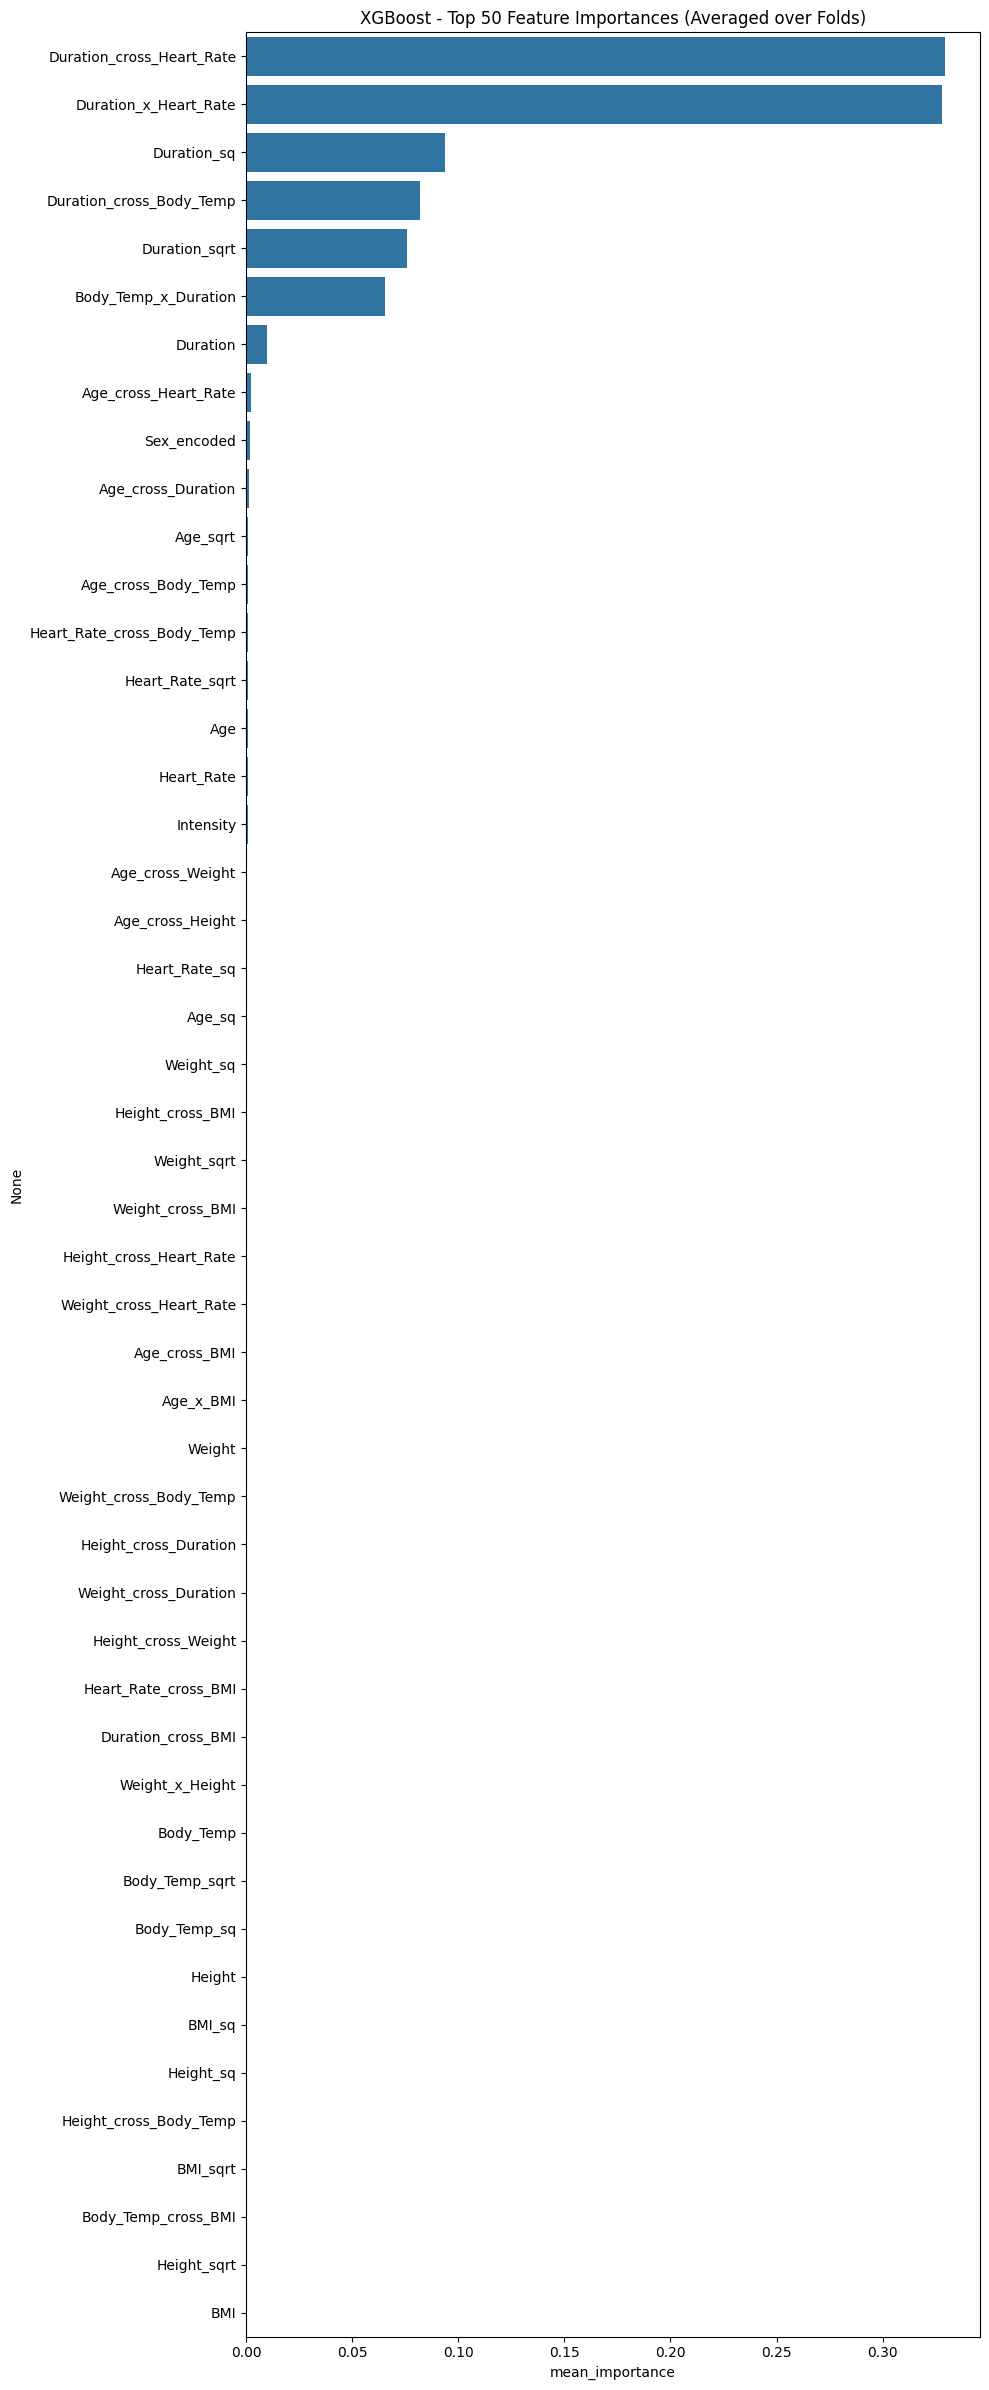


Saved XGBoost feature importances plot to xgb_feature_importances.png

Notebook execution finished.


In [8]:
# --- 7. Feature Importances (Example for XGBoost) ---
# You can create similar plots for LGBM and CatBoost
# Averaging feature importances across folds
if 'xgb' in oof_preds and not xgb_feature_importances.empty: # Check if XGBoost ran and importances were collected
    xgb_feature_importances['mean_importance'] = xgb_feature_importances.mean(axis=1)
    xgb_feature_importances.sort_values(by='mean_importance', ascending=False, inplace=True)

    plt.figure(figsize=(10, max(15, len(features) // 2))) # Adjust height based on num features
    sns.barplot(x='mean_importance', y=xgb_feature_importances.index[:50], data=xgb_feature_importances.head(50)) # Top 50
    plt.title('XGBoost - Top 50 Feature Importances (Averaged over Folds)')
    plt.tight_layout()
    plt.savefig('xgb_feature_importances.png')
    plt.show()
    print("\nSaved XGBoost feature importances plot to xgb_feature_importances.png")

print("\nNotebook execution finished.")